# QoL Monitor - Data Preprocessing

This notebook was created to help process the data collected by the QoL Monitor application. QoL Monitor is an Android application built to collect contextual and health data from users. In the current version, we collect sociodemographic and anthropometric data, sleep duration, daily steps, calories spent, physical activities, heart rate, location, apps usage time, and the number of calls made or received. To do that, it was necessary to integrate our app with the Google Fit API. Thus, users who participate in this study can use different wearables as long as they are integrated with the Google Fit account.

The following image describes the flow for getting the data.

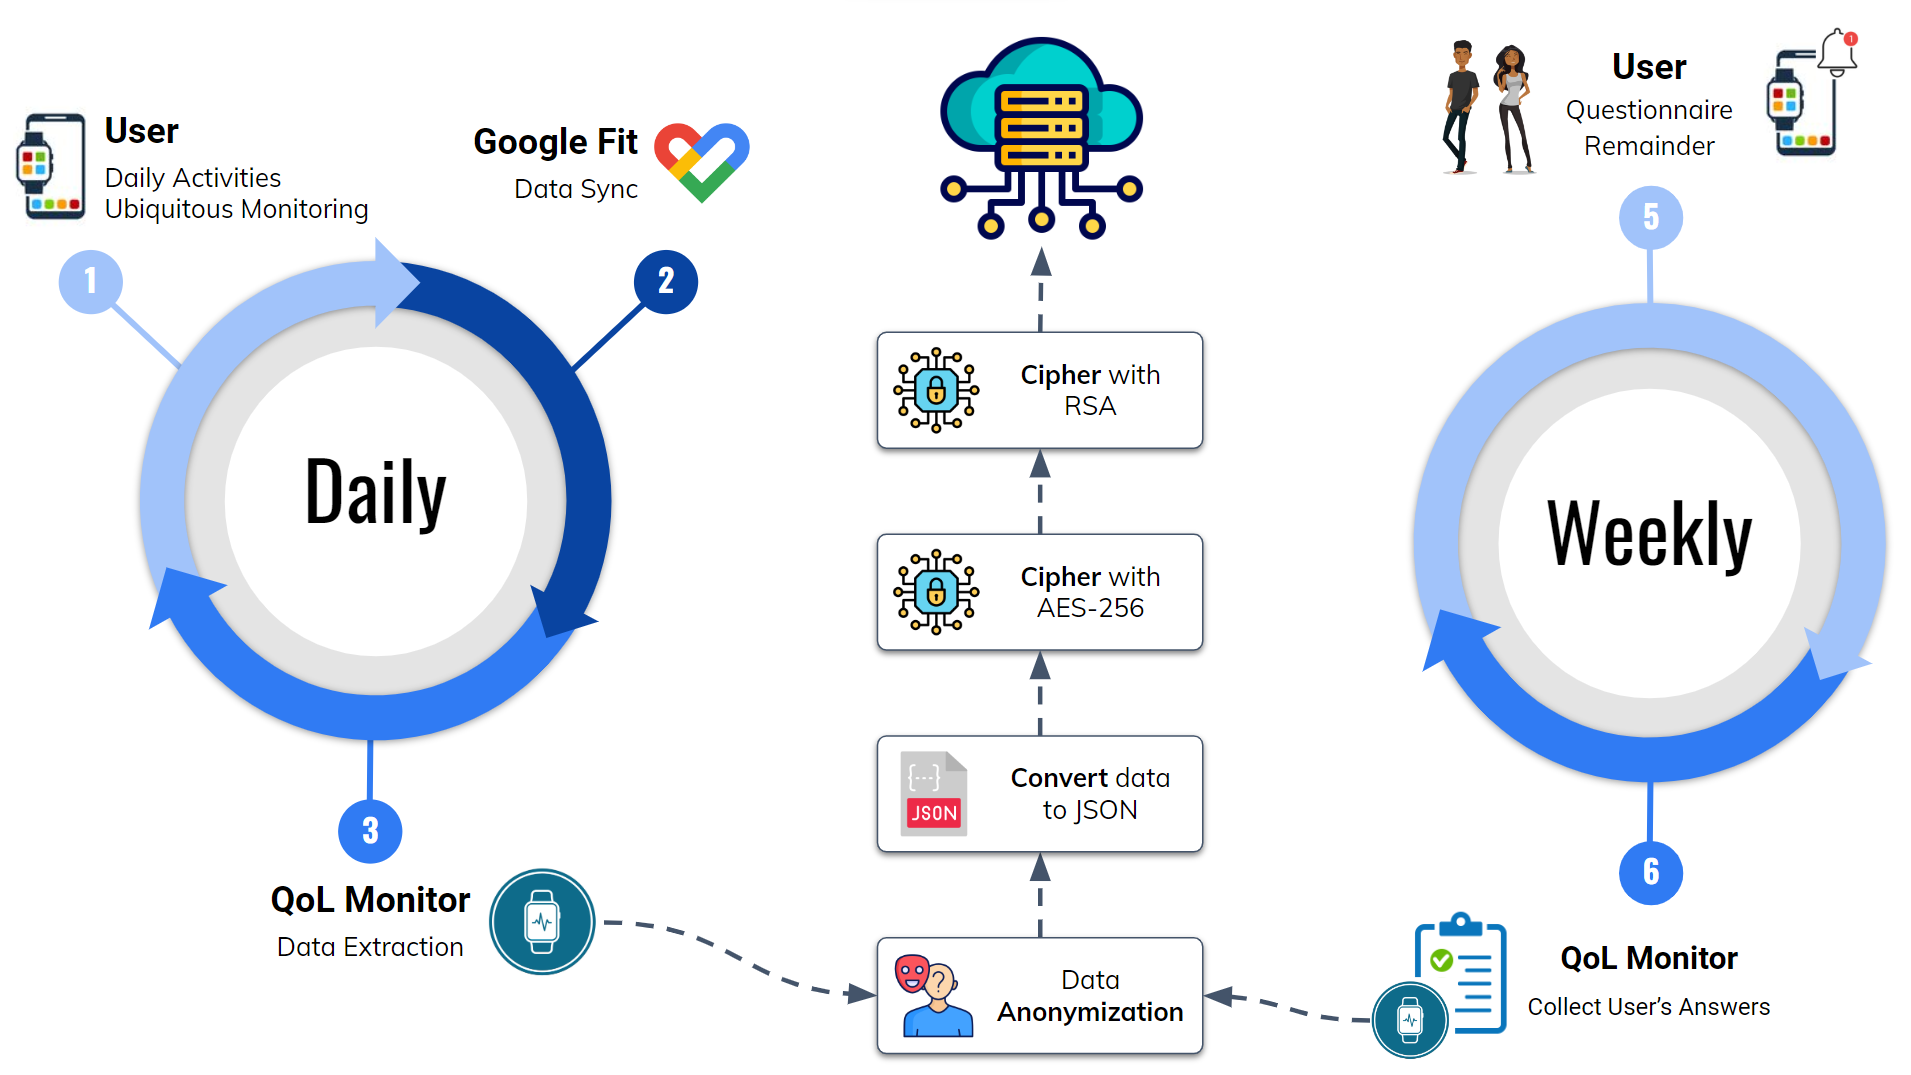

## Required Installs

In [1]:
pip install arff

  Preparing metadata (setup.py) ... - \ done
  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4970 sha256=8de5a44d334d09e46092b4c4bea635ef19a765686c42f47c56f2204b97417456
  Stored in directory: /root/.cache/pip/wheels/0c/39/12/4d8ff491018bce2dd9cc6034298f27399c7f4fd4063187f7be
Successfully built arff
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install hrv-analysis

Note: you may need to restart the kernel to use updated packages.


## Required Imports

In [3]:
import math
import arff
import requests
import numpy as np
import scipy.stats
import pandas as pd
from lxml import etree
from datetime import date
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from hrvanalysis import get_time_domain_features
from oauth2client.client import GoogleCredentials
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
#plt.style.use('ggplot')

## Getting Raw Data

In [4]:
base_path = '/kaggle/input/self-reported-qol/20230120-data-collector-'

### Participant Data

In [5]:
filepath = base_path + 'participant.csv'
df_participant = pd.read_csv(filepath)
df_participant.head(3)

,Timestamp,Remove,ID,Age,Wearable,SpecificAge,Group,Manufacturer,Smartphone,Gender,Income,Children,EduLevel,FamilyArr,Residence,Profession,MaritalStatus
0,23/12/2021 12:13:48,No,D39iyp2dlm,30–39,Mi Band,34,Initial Set,Samsung,Samsung SM-J810M,Masculino,0 a 1 vezes o salário mínimo,1 ou 2,Graduação,Mora com mais 1 ou 2 pessoas,Área urbana,Autônomo,Casado(a)
1,23/12/2021 14:01:23,No,vCTkloMaa0,30–39,AmazFit Bit S,30,Initial Set,Samsung,Samsung SM-A205G,Feminino,8 a 10,1 ou 2,Pós-Graduação,Mora com mais 1 ou 2 pessoas,Área urbana,Trabalhador período completo,Casado(a)
2,24/12/2021 14:00:32,No,4KIVcPBHLi,18–29,Mi Band,28,Initial Set,Xiaomi,Xiaomi M2007J20CG,Masculino,2 a 4,Nenhum,Pós-Graduação,Mora com mais 1 ou 2 pessoas,Área urbana,Estudante,Solteiro(a)


### Daily Register

In [6]:
filepath = base_path + 'dailyRegister.csv'
df_registers = pd.read_csv(filepath)
df_registers.head(3)

,Timestamp,ID,Day,Height,Weight,Steps,Calories,LightSleep,DeepSleep,REMSleep,...,IncomingCallsAverageDuration,OutgoingCallsAverageDuration,HeartRate,DifferentLocations,DifferentWifi,WhatsApp InVoice,WhatsApp InVideo,WhatsApp OutVoice,WhatsApp OutVideo,WhatsApp Notification
0,23/12/2021 12:13:49,D39iyp2dlm,20211223-12:07:36,1.55,60.0,"3,148.00","1,426.80",0.00,0.00,0.00,...,16.00,44.00,[],0,0,0,0,0,0,0
1,23/12/2021 13:59:59,ydun27JYqN,20211223-14:00:02,1.78,83.0,"2,677.00","1,791.74","24,660.00",780.00,0.00,...,0.00,0.00,[102;111;112;94;98;83;92;82;91;82;90;82;101;99...,7,0,0,0,0,0,0
2,23/12/2021 14:01:24,vCTkloMaa0,20211223-14:01:27,1.53,62.0,"6,924.00","1,595.08","5,700.00","4,800.00",0.00,...,0.00,0.00,[57;61;57;60;62;63;59;64;62;70;64;52;47;56;57;...,0,0,0,0,0,0,0


### Apps Usage

In [7]:
filepath = base_path + 'appsUsage.csv'
df_apps_usage = pd.read_csv(filepath)

filepath = base_path + 'appsCategory.csv'
df_apps_category = pd.read_csv(filepath)

# Creating new column
df_apps_usage['AppCategory'] = ''
df_apps_category['Package'] = df_apps_category['Package'].astype(str)

# Update AppCategory Column
for i, row in df_apps_usage.iterrows():
    app_type = str(row['AppType'])
    # Check if it's a package
    if "." in app_type:
        # Check if this package was registered in df_apps_category
        result = df_apps_category.index[df_apps_category['Package'] == app_type].tolist()
        if len(result) == 1:
            df_apps_usage.at[i, 'AppCategory'] = df_apps_category['Category'][result[0]]
    # Check if it's the main android package
    elif "android" == app_type:
        df_apps_usage.at[i, 'AppCategory'] = "System"
    # It already has the category registered in type
    else: 
        df_apps_usage.at[i, 'AppCategory'] = app_type

df_apps_usage.head(3)

,Timestamp,ID,Day,AppType,TimeInForeground,AppCategory
0,23/12/2021 12:13:49,D39iyp2dlm,20211223-12:07:36,com.whatsapp,5329602,Communication
1,23/12/2021 12:13:49,D39iyp2dlm,20211223-12:07:36,com.whatsapp.w4b,2364617,Communication
2,23/12/2021 12:13:50,D39iyp2dlm,20211223-12:07:36,com.sec.android.app.launcher,1649539,Personalization


#### Scraping app category

In [8]:
# Scraping function
def custom_selector(tag):
    return tag.name == "a" and tag.has_attr("aria-label") and "category" in tag.get("href")

def getPlayStoreCategory(package):
    try:
        html = requests.get("https://play.google.com/store/apps/details?id=" + package + "&hl=en&gl=US").content
        soup = BeautifulSoup(html, 'html.parser')
        dom = etree.HTML(str(soup))
        cat_list = soup.findAll(custom_selector)
        return str(cat_list[0]['aria-label'])
    except:
        return str('Others')

In [9]:
# Unique values in AppType Column from df_apps_usage
app_type_arr = df_apps_usage['AppType'].explode().unique()

# Unique values in Package Column from df_apps_category
app_category_arr = df_apps_category['Package'].explode().unique()

# Removing elements already registered
packages_to_find = []
for app_type in app_type_arr:
    if app_type not in app_category_arr and "." in app_type:
        packages_to_find.append(app_type)

df_apps_category['Category'].astype(str)

for package in packages_to_find:
    play_category = getPlayStoreCategory(package)
    df_apps_category = pd.concat([df_apps_category, 
        pd.DataFrame.from_records([{
            'Package' : package, 
            'Category': play_category,
            'apps-category.properties': package + '=' + play_category}])], ignore_index = True)
    
# New update after scraping date
for i, row in df_apps_usage.iterrows():
    app_type = str(row['AppType'])
    # Check if it's a package
    if "." in app_type:
        # Check if this package was registered in df_apps_category
        result = df_apps_category.index[df_apps_category['Package'] == app_type].tolist()
        if len(result) == 1:
            df_apps_usage.at[i, 'AppCategory'] = df_apps_category['Category'][result[0]]
            
df_apps_usage.head(3)

,Timestamp,ID,Day,AppType,TimeInForeground,AppCategory
0,23/12/2021 12:13:49,D39iyp2dlm,20211223-12:07:36,com.whatsapp,5329602,Communication
1,23/12/2021 12:13:49,D39iyp2dlm,20211223-12:07:36,com.whatsapp.w4b,2364617,Communication
2,23/12/2021 12:13:50,D39iyp2dlm,20211223-12:07:36,com.sec.android.app.launcher,1649539,Personalization


In [10]:
df_apps_category.to_csv('20230120-data-collector-appsCategory.csv', index=False)

### Physical Activities

In [11]:
filepath = base_path + 'physicalActivities.csv'
df_phy_acts = pd.read_csv(filepath)
df_phy_acts.head(3)

,Timestamp,ID,Day,Description,Duration,DurationAsString,Segments
0,23/12/2021 12:13:49,D39iyp2dlm,20211223-12:07:36,Unknown (unable to detect activity),84599000,23:29:59,2
1,23/12/2021 12:13:49,D39iyp2dlm,20211223-12:07:36,Walking,1800000,00:30:00,1
2,23/12/2021 13:59:59,ydun27JYqN,20211223-14:00:02,Walking,1860000,00:31:00,4


### Questionnaire Answers

In [12]:
filepath = base_path + 'WHOQOL-BREF.csv'
df_answers = pd.read_csv(filepath)
df_answers.head(3)

,Timestamp,ID,Day,QuestionsID,AnswerID,Answer
0,24/12/2021 09:07:51,XoyogQMtou,20211224-09:07:49,1,3,Boa
1,24/12/2021 09:07:51,XoyogQMtou,20211224-09:07:49,2,3,Satisfeito
2,24/12/2021 09:07:51,XoyogQMtou,20211224-09:07:49,3,0,Nada


## Cleaning Data

### Standardizing terms

The application can be accessed in English or Portuguese. Thus, users' responses can be recorded in both languages. Therefore, we need to standardize the terms for the English language before starting to process the data.

In [13]:
df_participant['Gender'].replace({"Masculino":"Male", "Feminino": "Female"}, inplace=True)
df_participant['Income'].replace({
    "0 a 1 vezes o salário mínimo":"0 to 1 times the minimium wage", 
    "2 a 4": "2 to 4",
    "5 a 7": "5 to 7",
    "8 a 10": "8 to 10",
    "Mais que 10 vezes": "More than 10 times"}, 
    inplace=True)
df_participant['Income'].replace({
    "0 to 1 times the minimium wage": "0 to 1", 
    "More than 10 times": ">10"}, 
    inplace=True)
df_participant['Children'].replace({
    "Nenhum": "None", 
    "1 ou 2": "1 or 2",
    "3 ou 4": "3 or 4", 
    "Mais que 4": "More than 4"}, 
    inplace=True)
df_participant['EduLevel'].replace({
    "Ensino fundamental": "Primary level", 
    "Ensino médio": "Secondary level",
    "Graduação": "University level", 
    "Pós-Graduação": "Postgraduate level"}, 
    inplace=True)
df_participant['FamilyArr'].replace({
    "Mora sozinho": "Lives alone", 
    "Mora com mais 1 ou 2 pessoas": "Lives with more 1 or 2",
    "Mora com mais 3 ou 4": "Lives with more 3 or 4", 
    "Mora com 5 or mais pessoas": "Lives with 5 or more"}, 
    inplace=True)
df_participant['Residence'].replace({
    "Área urbana": "Urban area", 
    "Área rural": "Rural area"}, 
    inplace=True)
df_participant['Profession'].replace({
    "Estudante": "Student", 
    "Trabalhador meio período": "Part-time worker",
    "Trabalhador período completo": "Full-time worker", 
    "Autônomo": "Self-employed",
    "Desempregado": "Unemployed",
    "Aposentado": "Retired"}, 
    inplace=True)
df_participant['MaritalStatus'].replace({
    "Solteiro(a)": "Single", 
    "Casado(a)": "Married",
    "Divorciado(a)": "Divorced", 
    "Vióvo(a)": "Widowed",
    "Viúvo(a)": "Widowed"}, 
    inplace=True)
df_participant.head()

,Timestamp,Remove,ID,Age,Wearable,SpecificAge,Group,Manufacturer,Smartphone,Gender,Income,Children,EduLevel,FamilyArr,Residence,Profession,MaritalStatus
0,23/12/2021 12:13:48,No,D39iyp2dlm,30–39,Mi Band,34,Initial Set,Samsung,Samsung SM-J810M,Male,0 to 1,1 or 2,University level,Lives with more 1 or 2,Urban area,Self-employed,Married
1,23/12/2021 14:01:23,No,vCTkloMaa0,30–39,AmazFit Bit S,30,Initial Set,Samsung,Samsung SM-A205G,Female,8 to 10,1 or 2,Postgraduate level,Lives with more 1 or 2,Urban area,Full-time worker,Married
2,24/12/2021 14:00:32,No,4KIVcPBHLi,18–29,Mi Band,28,Initial Set,Xiaomi,Xiaomi M2007J20CG,Male,2 to 4,None,Postgraduate level,Lives with more 1 or 2,Urban area,Student,Single
3,24/12/2021 14:01:13,No,XoyogQMtou,18–29,Galaxy Fit 2,19,Initial Set,Samsung,Samsung SM-A750G,Male,0 to 1,None,University level,Lives with 5 or more,Urban area,Student,Single
4,24/12/2021 14:12:03,No,WjTSJGdBQj,30–39,AmazFit GTS,33,Initial Set,Xiaomi,Xiaomi M2101K7AG,Male,2 to 4,None,Postgraduate level,Lives with more 3 or 4,Urban area,Student,Single


### Removing Inconsistencies

In this case, we must remove the daily logs, duplicate data, data with wrong keys and data without sleep and heart rate log.

#### Invalid keys

In [14]:
# Removing invalid keys
def remove_invalid_keys(df, name):
    before = len(df.index)
    df.drop(df[df['ID'].map(len) < 10].index, inplace=True)
    after = len(df.index)

    print('It were removed', (before - after), 'items from', name, 'because ID must have at least ten characters.')

remove_invalid_keys(df_participant, 'Participantes')
remove_invalid_keys(df_registers,   'Registers')
remove_invalid_keys(df_answers,     'Answers')
remove_invalid_keys(df_phy_acts,    'Physical Activities')
remove_invalid_keys(df_apps_usage,  'Apps Usage')

It were removed 0 items from Participantes because ID must have at least ten characters.
It were removed 0 items from Registers because ID must have at least ten characters.
It were removed 0 items from Answers because ID must have at least ten characters.
It were removed 360 items from Physical Activities because ID must have at least ten characters.
It were removed 0 items from Apps Usage because ID must have at least ten characters.


#### Users with Inconsistent Data

In [15]:
users_to_remove = df_participant.loc[df_participant['Remove'] == 'Yes', 'ID'].values

def remove_users_with_inconsistencies(df, df_name):
    before = len(df.index)
    df2 = df[~df['ID'].isin(users_to_remove)]
    after = len(df2.index)
    print(f"It were removed {before - after} items from {df_name}, because these users has inconsistent data.")
    return df2

df_participant = remove_users_with_inconsistencies(df_participant, 'Participantes')
df_registers   = remove_users_with_inconsistencies(df_registers,   'Registers')
df_phy_acts    = remove_users_with_inconsistencies(df_phy_acts,    'Physical Activities')
df_apps_usage  = remove_users_with_inconsistencies(df_apps_usage,  'Apps Usage')
df_answers     = remove_users_with_inconsistencies(df_answers,     'Answers')

It were removed 5 items from Participantes, because these users has inconsistent data.
It were removed 1796 items from Registers, because these users has inconsistent data.
It were removed 2203 items from Physical Activities, because these users has inconsistent data.
It were removed 29009 items from Apps Usage, because these users has inconsistent data.
It were removed 72 items from Answers, because these users has inconsistent data.


#### Without sleep

In [16]:
# Removing data without sleep data
df_registers["LightSleep"] = df_registers["LightSleep"].replace(',','', regex=True)
df_registers["DeepSleep"]  = df_registers["DeepSleep"] .replace(',','', regex=True)
df_registers["REMSleep"]   = df_registers["REMSleep"]  .replace(',','', regex=True)
df_registers["AwakeSleep"] = df_registers["AwakeSleep"].replace(',','', regex=True)

df_registers["LightSleep"] = df_registers["LightSleep"].astype(float)
df_registers["DeepSleep"]  = df_registers["DeepSleep"] .astype(float)
df_registers["REMSleep"]   = df_registers["REMSleep"]  .astype(float)
df_registers["AwakeSleep"] = df_registers["AwakeSleep"].astype(float)

before = len(df_registers.index)
df_registers = df_registers.drop(df_registers[
                                              (df_registers['LightSleep'] == 0) & 
                                              (df_registers['DeepSleep']  == 0) &
                                              (df_registers['REMSleep']   == 0) &
                                              (df_registers['AwakeSleep'] == 0)].index)
after = len(df_registers.index)

print('It were removed', (before - after), 'items df_registers, because sleep is required.')

It were removed 11437 items df_registers, because sleep is required.


#### Without heart rate

In [17]:
# Removing data without heart rate
before = len(df_registers.index)
df_registers = df_registers.drop(df_registers[(df_registers['HeartRate'] == '[]')].index)
after = len(df_registers.index)

print('It were removed', (before - after), 'items df_registers, because heart rate is required.')

It were removed 7 items df_registers, because heart rate is required.


#### Without steps and calories

In [18]:
# Removing data without steps and calories
df_registers["Steps"]    = df_registers["Steps"]   .replace(',','', regex=True)
df_registers["Calories"] = df_registers["Calories"].replace(',','', regex=True)

df_registers["Steps"]    = df_registers["Steps"]   .astype(float)
df_registers["Calories"] = df_registers["Calories"].astype(float)

before = len(df_registers.index)
df_registers = df_registers.drop(df_registers[(df_registers['Steps'] == 0)].index)
after = len(df_registers.index)

print('It were removed', (before - after), 'items df_registers, because daily steps is required.')

before = len(df_registers.index)
df_registers = df_registers.drop(df_registers[(df_registers['Calories'] == 0)].index)
after = len(df_registers.index)

print('It were removed', (before - after), 'items df_registers, because daily calories is required.')

It were removed 1 items df_registers, because daily steps is required.
It were removed 47 items df_registers, because daily calories is required.


#### Without height and weight

In [19]:
# Removing data without height and weight
df_registers["Height"] = df_registers["Height"].replace(',','', regex=True)
df_registers["Weight"] = df_registers["Weight"].replace(',','', regex=True)

df_registers["Height"] = df_registers["Height"].astype(float)
df_registers["Weight"] = df_registers["Weight"].astype(float)

before = len(df_registers.index)
df_registers = df_registers.drop(df_registers[(df_registers['Height'] == 0)].index)
after = len(df_registers.index)

print('It were removed', (before - after), 'items df_registers, because height is required.')

before = len(df_registers.index)
df_registers = df_registers.drop(df_registers[(df_registers['Weight'] == 0)].index)
after = len(df_registers.index)

print('It were removed', (before - after), 'items df_registers, because weight is required.')

It were removed 85 items df_registers, because height is required.
It were removed 0 items df_registers, because weight is required.


#### Apps usage from exclusion list

In [20]:
exclusion_list = ['Others', 'Tools', 'System', 'android', 'Libraries & Demo', 'Personalization']

before = len(df_apps_usage.index)
df_apps_usage = df_apps_usage.drop(df_apps_usage[(df_apps_usage['AppCategory'].isin(exclusion_list))].index)
after = len(df_apps_usage.index)

print('It were removed', (before - after), 'items df_apps_usage based on exclusion list: Others, Tools, System and Android')

It were removed 30799 items df_apps_usage based on exclusion list: Others, Tools, System and Android


In [21]:
df_apps_usage['AppCategory'].replace({
    "Video Players & Editors": "Video",
    "Music & Audio"    : "Music", 
    "Health & Fitness" : "Health",
    "Medical"          : "Health",
    "Travel & Local"   : "Travel",
    "Food & Drink"     : "Food",
    "Maps & Navigation": "Maps",
    "Auto & Vehicles"  : "Vehicles",
    "News & Magazines" : "News",
    "Art & Design"     : "Art",
    "Libraries & Demo" : "Libraries",
    "Books & Reference": "Books",
    "House & Home"     : "House",
    "Simulation"       : "Games",
    "Puzzle"           : "Games",
    "Adventure"        : "Games",
    "Action"           : "Games",
    "Arcade"           : "Games",
    "Card"             : "Games",
    "Board"            : "Games",
    "Racing"           : "Games",
    "Trivia"           : "Games",
    "Word"             : "Games",
    "Strategy"         : "Games",
    "Role Playing"     : "Games",
    "Casino"           : "Games",
    "Casual"           : "Games",
    "Comics"           : "Entertainment"
    }, inplace=True)

In [22]:
df_apps_usage['AppCategory'].unique()

array(['Communication', 'Social', 'Photography', 'Games', 'Music',
       'Health', 'Travel', 'Productivity', 'Finance', 'Entertainment',
       'Video', 'Food', 'Business', 'Shopping', 'Lifestyle', 'Maps',
       'Vehicles', 'Sports', 'News', 'Art', 'Weather', 'Events',
       'Education', 'Books', 'Beauty', 'House', 'Educational', 'Dating'],
      dtype=object)

#### Unknown physical activity

In [23]:
# Removing physical activities classified as 'Unknown (unable to detect activity)'
exclusion_list = ['Unknown (unable to detect activity)']

before = len(df_phy_acts.index)
df_phy_acts = df_phy_acts.drop(df_phy_acts[(df_phy_acts['Description'].isin(exclusion_list))].index)
after = len(df_phy_acts.index)

df_phy_acts['Description'].replace({"Other (unclassified fitness activity)": "Other"}, inplace=True)

print('It were removed', (before - after), 'items df_phy_acts based on exclusion list: Unknown (unable to detect activity)')

It were removed 13374 items df_phy_acts based on exclusion list: Unknown (unable to detect activity)


#### Updating incorrect answer date

In [24]:
# Updating day column to remove hour 
df_answers['Day'] = df_answers['Day'].str.split('-').str[0]

# Correcting questionnaire date as user may have forgotten to answer on Sunday
count = 0
for i, row in df_answers.iterrows():
    answer_day = datetime.strptime(row['Day'], '%Y%m%d')
    correct_day = answer_day
    if(answer_day.weekday() == 0):     # Monday
        correct_day = answer_day - timedelta(days=1)
        count += 1
    elif (answer_day.weekday() == 1):  # Tuesday
        correct_day = answer_day - timedelta(days=2)
        count += 1
    elif (answer_day.weekday() == 2):  # Wednesday
        correct_day = answer_day - timedelta(days=3)
        count += 1
    elif (answer_day.weekday() == 3):  # Thursday
        correct_day = answer_day - timedelta(days=4)
        count += 1
    elif (answer_day.weekday() == 4):  # Friday
        correct_day = answer_day - timedelta(days=5)
        count += 1
    elif (answer_day.weekday() == 5):  # Saturday
        correct_day = answer_day - timedelta(days=6)
        count += 1

    correct_day_str = correct_day.strftime('%Y%m%d')
    df_answers.at[i, 'Day'] = correct_day_str

# creating a combined ID with answer ID and Day
df_answers['CombinedID'] = df_answers['ID'] + '-' + df_answers['Day']

print('It were ajusted', count, 'registers.')

It were ajusted 1764 registers.


#### Duplicate

##### Participant

In [25]:
# Updating timestamp to be considered as datetime
df_participant['Timestamp'] = pd.to_datetime(df_participant['Timestamp'])

before = len(df_participant.index)
df_participant = df_participant.sort_values('Timestamp').drop_duplicates(subset=['ID'], keep='last')
after = len(df_participant.index)

print('It were removed', (before - after), 'duplicate items from df_participant considering ID and day. The most current records have been kept.')

It were removed 0 duplicate items from df_participant considering ID and day. The most current records have been kept.


##### Registers

In [26]:
# Updating day column to remove hour
df_registers['Day'] = df_registers['Day'].str.split('-').str[0]

# Updating timestamp to be considered as datetime
df_registers['Timestamp'] = pd.to_datetime(df_registers['Timestamp'])

#df_registers.info()

# Removing duplicate
before = len(df_registers.index)
df_registers = df_registers.sort_values('Timestamp').drop_duplicates(subset=['ID', 'Day'], keep='last')
after = len(df_registers.index)

print('It were removed', (before - after), 'duplicate items from df_registers considering ID and day. The most current records have been kept.')

It were removed 552 duplicate items from df_registers considering ID and day. The most current records have been kept.


##### Apps Usage

In [27]:
# First step: removing hour information from day column
df_apps_usage['Day'] = df_apps_usage['Day'].str.split('-').str[0]

# Second step: updating timestamp to be considered as datetime
df_apps_usage['Timestamp'] = pd.to_datetime(df_apps_usage['Timestamp'])

# Thrid step: removing duplicates app usage for the same day
before = len(df_apps_usage.index)
df_apps_usage = df_apps_usage.sort_values('Timestamp').drop_duplicates(subset=['ID', 'Day', 'AppType'], keep='last')
after = len(df_apps_usage.index)

print('It were removed', (before - after), 'duplicate items from df_apps_usage considering ID, Day, and AppType. The most current records have been kept.')

It were removed 93063 duplicate items from df_apps_usage considering ID, Day, and AppType. The most current records have been kept.


##### Physical Activity

In [28]:
# First step: removing hour information from day column
df_phy_acts['Day'] = df_phy_acts['Day'].str.split('-').str[0]

# Second step: updating timestamp to be considered as datetime
df_phy_acts['Timestamp']= pd.to_datetime(df_phy_acts['Timestamp'])

# Thrid step: removing duplicates app usage for the same day
before = len(df_phy_acts.index)
df_phy_acts = df_phy_acts.sort_values('Timestamp').drop_duplicates(subset=['ID', 'Day', 'Description', 'Duration'], keep='last')
after = len(df_phy_acts.index)

print('It were removed', (before - after), 'duplicate items from df_phy_acts considering ID, Day, Description, and Duration. The most current records have been kept.')

It were removed 3505 duplicate items from df_phy_acts considering ID, Day, Description, and Duration. The most current records have been kept.


##### Answers

In [29]:
# Updating timestamp to be considered as datetime
df_answers['Timestamp'] = pd.to_datetime(df_answers['Timestamp'])

before = len(df_answers.index)
df_answers = df_answers.sort_values('Timestamp').drop_duplicates(subset=['ID', 'Day', 'QuestionsID'], keep='last')
after = len(df_answers.index)

print('It were removed', (before - after), 'duplicate items from df_answers considering ID, Day, and QuestionsID. The most current records have been kept.')

It were removed 162 duplicate items from df_answers considering ID, Day, and QuestionsID. The most current records have been kept.


### Transforming data

#### Processing Heart Rate

In [30]:
df_registers['mean_nni']    = 0.0
df_registers['sdnn']        = 0.0
df_registers['sdsd']        = 0.0
df_registers['nni_50']      = 0.0
df_registers['pnni_50']     = 0.0
df_registers['nni_20']      = 0.0
df_registers['pnni_20']     = 0.0
df_registers['rmssd']       = 0.0
df_registers['median_nni']  = 0.0
df_registers['range_nni']   = 0.0
df_registers['cvsd']        = 0.0
df_registers['cvnni']       = 0.0
df_registers['mean_hr']     = 0.0
df_registers['max_hr']      = 0.0
df_registers['min_hr']      = 0.0
df_registers['std_hr']      = 0.0

for i, row in df_registers.iterrows():
    hr_str_array = row['HeartRate'].replace('[', '').replace(']', '').strip().split(';')
    hr_array = list(map(int, hr_str_array))
    # https://aura-healthcare.github.io/hrv-analysis/readme.html
    # rr_intervals_list contains integer values of RR-interval
    rr_intervals_list = 60000//np.array(hr_array)
    # This remove outliers from signal
    rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list, low_rri=300, high_rri=2000, verbose=False)
    # This replace outliers nan values with linear interpolation
    interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method="linear")
    # This remove ectopic beats from signal
    nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik", verbose=False)
    # This replace ectopic beats nan values with linear interpolation
    interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
    # get time domain features
    time_domain_features = get_time_domain_features(interpolated_nn_intervals)
    
    df_registers.at[i, 'mean_nni']   = time_domain_features['mean_nni']
    df_registers.at[i, 'sdnn']       = time_domain_features['sdnn']
    df_registers.at[i, 'sdsd']       = time_domain_features['sdsd']
    df_registers.at[i, 'nni_50']     = time_domain_features['nni_50']
    df_registers.at[i, 'pnni_50']    = time_domain_features['pnni_50']
    df_registers.at[i, 'nni_20']     = time_domain_features['nni_20']
    df_registers.at[i, 'pnni_20']    = time_domain_features['pnni_20']
    df_registers.at[i, 'rmssd']      = time_domain_features['rmssd']
    df_registers.at[i, 'median_nni'] = time_domain_features['median_nni']
    df_registers.at[i, 'range_nni']  = time_domain_features['range_nni']
    df_registers.at[i, 'cvsd']       = time_domain_features['cvsd']
    df_registers.at[i, 'cvnni']      = time_domain_features['cvnni']
    df_registers.at[i, 'mean_hr']    = time_domain_features['mean_hr']
    df_registers.at[i, 'max_hr']     = time_domain_features['max_hr']
    df_registers.at[i, 'min_hr']     = time_domain_features['min_hr']
    df_registers.at[i, 'std_hr']     = time_domain_features['std_hr']

df_registers.head()

,Timestamp,ID,Day,Height,Weight,Steps,Calories,LightSleep,DeepSleep,REMSleep,...,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr
2,2021-12-23 14:01:24,vCTkloMaa0,20211223,1.53,62.0,6924.0,1595.08,5700.0,4800.0,0.0,...,84.180791,98.561719,1111.0,584.0,0.088068,0.096874,54.137999,77.021823,44.020543,5.501269
4,2021-12-23 14:55:48,WPooa9cRhe,20211223,1.63,73.0,7420.0,1804.50,16980.0,4560.0,5280.0,...,63.376252,60.116803,869.0,780.0,0.069453,0.216576,73.346670,135.135135,49.019608,19.324795
7,2021-12-24 14:01:13,XoyogQMtou,20211224,1.65,79.0,7630.0,1650.70,18663.0,3540.0,2160.0,...,61.863593,58.430411,800.0,790.0,0.071663,0.200009,76.835501,138.248848,49.019608,16.609666
8,2021-12-24 14:09:31,WPooa9cRhe,20211224,1.63,73.0,5401.0,1868.60,15720.0,6240.0,7440.0,...,71.259259,63.550729,845.0,852.0,0.074371,0.210488,74.268377,161.290323,49.019608,20.460960
9,2021-12-24 14:12:03,WjTSJGdBQj,20211224,1.80,150.0,361.0,2396.97,30840.0,1440.0,0.0,...,68.671679,53.151059,652.0,357.0,0.081117,0.096217,92.422807,117.187500,69.044879,8.931918


#### Processing Apps Usage

In [31]:
# TimeInForeground is measured milliseconds
df_apps_usage['TimeInForeground'] = df_apps_usage['TimeInForeground'].astype(int)

usage_grouped = df_apps_usage.groupby(['ID','Day', 'AppCategory'])['TimeInForeground'].sum()
usage_grouped

ID          Day       AppCategory  
2XgOFdSrM0  20221005  Business            11815
                      Communication    11108709
                      Education             898
                      Finance           1383185
                      Health            1914503
                                         ...   
ydun27JYqN  20220910  Productivity       425069
                      Shopping           411221
                      Social           10783575
                      Travel              22594
                      Video               64958
Name: TimeInForeground, Length: 40425, dtype: int64

#### Processing Physical Activities

In [32]:
# Duration is measured milliseconds
df_phy_acts['Duration'] = df_phy_acts['Duration'].astype(int)

phy_acts_grouped = df_phy_acts.groupby(['ID','Day', 'Description'])['Duration'].sum()
phy_acts_grouped

ID          Day       Description
2XgOFdSrM0  20221005  Other           1260000
                      Walking         1080000
            20221006  Other           3360000
                      Walking         3300000
            20221007  Walking         2160000
                                       ...   
ydun27JYqN  20220617  Walking         9540000
            20220618  Other           8460000
                      Walking        10500000
            20220619  Other           3780000
                      Walking         5700000
Name: Duration, Length: 4479, dtype: int64

#### Calculating QoL score

In [33]:
combinedIDList = list(df_answers['CombinedID'].unique())
qolPhyScoreList = [0] * len(combinedIDList)
qolPsyScoreList = [0] * len(combinedIDList)

print('Calculating raw values for', len(combinedIDList), 'unique entries.')

for cid in combinedIDList:
    arr = cid.split('-')
    id = arr[0]
    day = arr[1]
    for index, row in df_answers.iterrows():
                   
        if(id == row['ID'] and day == row['Day']):
            '''if(cid == 'D39iyp2dlm-20220109'):
                print(row['ID'], row['Day'])
                print(combinedIDList.index(cid))
                print(qolPhyScoreList[i])'''
            
            i = combinedIDList.index(cid)
            qScore = int(row['AnswerID']) + 1
            
            if((row['QuestionsID'] == 3 or row['QuestionsID'] == 4)):
                qolPhyScoreList[i] += 6 - qScore

            if((row['QuestionsID'] == 10 
                or row['QuestionsID'] == 15
                or row['QuestionsID'] == 16
                or row['QuestionsID'] == 17
                or row['QuestionsID'] == 18)):
                qolPhyScoreList[i] += qScore

            if(row['QuestionsID'] == 26):
                qolPsyScoreList[i] += 6 - qScore
            
            if((row['QuestionsID']    == 5
                or row['QuestionsID'] == 6
                or row['QuestionsID'] == 7
                or row['QuestionsID'] == 11
                or row['QuestionsID'] == 19)):
                qolPsyScoreList[i] += qScore
                
for i in range(len(combinedIDList)):
    qolPhyScoreList[i] = math.floor(((((qolPhyScoreList[i]/7.0)*4.0)-4.0)/16.0)*100.0)
    qolPsyScoreList[i] = math.floor(((((qolPsyScoreList[i]/6.0)*4.0)-4.0)/16.0)*100.0)
    if(qolPhyScoreList[i] < 0 or qolPhyScoreList[i] > 100):
        print("Issue:", combinedIDList[i], qolPhyScoreList[i], qolPsyScoreList[i])
    if(qolPsyScoreList[i] < 0 or qolPsyScoreList[i] > 100):
        print("Issue:", combinedIDList[i], qolPhyScoreList[i], qolPsyScoreList[i])
    
score_matrix = [combinedIDList, qolPhyScoreList, qolPsyScoreList]
df_qol_score = pd.DataFrame(score_matrix).transpose()
df_qol_score.columns = ['combined_id', 'physical_score', 'psychological_score']
df_qol_score['id'] = df_qol_score['combined_id'].str.split('-').str[0]
df_qol_score['day'] = df_qol_score['combined_id'].str.split('-').str[1]

df_qol_score.head()

Calculating raw values for 496 unique entries.


,combined_id,physical_score,psychological_score,id,day
0,XoyogQMtou-20211219,82,66,XoyogQMtou,20211219
1,WjTSJGdBQj-20211226,60,62,WjTSJGdBQj,20211226
2,XoyogQMtou-20211226,75,62,XoyogQMtou,20211226
3,ydun27JYqN-20211226,53,45,ydun27JYqN,20211226
4,WPooa9cRhe-20211226,78,66,WPooa9cRhe,20211226


## Joining Data

### Daily Register and Participant Data

In [34]:
# Merge datasets (daily register and participant data) with a Left Join
left_merged = pd.merge(df_registers, df_participant, how="left", on=["ID"])
left_merged = left_merged.drop(columns='Timestamp_y')
left_merged.rename(columns={'Timestamp_x': 'timestamp'}, inplace=True)
left_merged.columns = map(str.lower, left_merged.columns)
left_merged.sort_values('id')

left_merged['ref_day'] = ""
left_merged['phy_ref_score'] = 0
left_merged['psy_ref_score'] = 0

for i, row in left_merged.iterrows():
    reg_day = datetime.strptime(row['day'], '%Y%m%d')
    ref_day = reg_day
    if(reg_day.weekday() == 0):     # Monday
        ref_day = reg_day + timedelta(days=6)
    elif (reg_day.weekday() == 1):  # Tuesday
        ref_day = reg_day + timedelta(days=5)
    elif (reg_day.weekday() == 2):  # Wednesday
        ref_day = reg_day + timedelta(days=4)
    elif (reg_day.weekday() == 3):  # Thursday
        ref_day = reg_day + timedelta(days=3)
    elif (reg_day.weekday() == 4):  # Friday
        ref_day = reg_day + timedelta(days=2)
    elif (reg_day.weekday() == 5):  # Saturday
        ref_day = reg_day + timedelta(days=1)
    elif (reg_day.weekday() == 6):  # Sunday
        ref_day = reg_day + timedelta(days=7)

    ref_day_str = ref_day.strftime('%Y%m%d')
    left_merged.at[i,'ref_day'] = ref_day_str

    cid = row['id'] + '-' + ref_day_str
    has_qol_score = False
    if(cid in combinedIDList): has_qol_score = True
    
    #if(not has_qol_score): # TODO: Check!
    #    print(row['id'], reg_day.strftime('%Y%m%d'), ref_day_str, cid, has_qol_score)

    if(has_qol_score):
        ref_i = combinedIDList.index(cid)
        left_merged.at[i,'phy_ref_score'] = qolPhyScoreList[ref_i]
        left_merged.at[i,'psy_ref_score'] = qolPsyScoreList[ref_i]

# Removing register without qol score
before = len(left_merged.index)
left_merged = left_merged.drop(left_merged[(left_merged['phy_ref_score'] == 0)].index)
after = len(left_merged.index)

print('It were removed', (before - after), 'items from left_merged because it was not found qol score.')

left_merged.head()

It were removed 420 items from left_merged because it was not found qol score.


,timestamp,id,day,height,weight,steps,calories,lightsleep,deepsleep,remsleep,...,income,children,edulevel,familyarr,residence,profession,maritalstatus,ref_day,phy_ref_score,psy_ref_score
1,2021-12-23 14:55:48,WPooa9cRhe,20211223,1.63,73.0,7420.0,1804.50,16980.0,4560.0,5280.0,...,8 to 10,None,University level,Lives with more 3 or 4,Urban area,Full-time worker,Single,20211226,78,66
2,2021-12-24 14:01:13,XoyogQMtou,20211224,1.65,79.0,7630.0,1650.70,18663.0,3540.0,2160.0,...,0 to 1,None,University level,Lives with 5 or more,Urban area,Student,Single,20211226,75,62
3,2021-12-24 14:09:31,WPooa9cRhe,20211224,1.63,73.0,5401.0,1868.60,15720.0,6240.0,7440.0,...,8 to 10,None,University level,Lives with more 3 or 4,Urban area,Full-time worker,Single,20211226,78,66
4,2021-12-24 14:12:03,WjTSJGdBQj,20211224,1.80,150.0,361.0,2396.97,30840.0,1440.0,0.0,...,2 to 4,None,Postgraduate level,Lives with more 3 or 4,Urban area,Student,Single,20211226,60,62
5,2021-12-25 14:00:15,WPooa9cRhe,20211225,1.63,73.0,4503.0,1758.03,16560.0,6120.0,5640.0,...,8 to 10,None,University level,Lives with more 3 or 4,Urban area,Full-time worker,Single,20211226,78,66


In [35]:
merged = left_merged
merged.columns = map(str.lower, merged.columns)
merged.sort_values('id')

,timestamp,id,day,height,weight,steps,calories,lightsleep,deepsleep,remsleep,...,income,children,edulevel,familyarr,residence,profession,maritalstatus,ref_day,phy_ref_score,psy_ref_score
1368,2022-10-10 19:07:11,2XgOFdSrM0,20221010,1.74,74.0,4055.0,1896.28,12840.0,4320.0,4980.0,...,5 to 7,None,University level,Lives with more 3 or 4,Urban area,Student,Single,20221016,78,50
1658,2022-12-14 19:10:14,2XgOFdSrM0,20221214,1.74,74.0,1985.0,1660.27,15540.0,5580.0,5160.0,...,5 to 7,None,University level,Lives with more 3 or 4,Urban area,Student,Single,20221218,67,33
1484,2022-10-23 19:09:14,2XgOFdSrM0,20221023,1.74,74.0,2861.0,1785.43,15000.0,4020.0,4140.0,...,5 to 7,None,University level,Lives with more 3 or 4,Urban area,Student,Single,20221030,78,41
1384,2022-10-14 19:08:10,2XgOFdSrM0,20221014,1.74,74.0,1808.0,1663.85,24480.0,4920.0,9000.0,...,5 to 7,None,University level,Lives with more 3 or 4,Urban area,Student,Single,20221016,78,50
1640,2022-12-10 19:15:44,2XgOFdSrM0,20221012,1.74,74.0,1979.0,1692.46,15600.0,4560.0,5520.0,...,5 to 7,None,University level,Lives with more 3 or 4,Urban area,Student,Single,20221016,78,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,2022-03-19 19:09:47,ydun27JYqN,20220319,1.78,84.4,4036.0,1894.28,19560.0,2880.0,0.0,...,>10,1 or 2,Postgraduate level,Lives with more 1 or 2,Urban area,Full-time worker,Married,20220320,46,33
526,2022-03-18 20:01:27,ydun27JYqN,20220318,1.78,84.4,4935.0,1931.58,22140.0,5340.0,0.0,...,>10,1 or 2,Postgraduate level,Lives with more 1 or 2,Urban area,Full-time worker,Married,20220320,46,33
404,2022-02-26 19:07:00,ydun27JYqN,20220226,1.78,84.4,4732.0,1907.50,23880.0,1080.0,0.0,...,>10,1 or 2,Postgraduate level,Lives with more 1 or 2,Urban area,Full-time worker,Married,20220227,46,37
367,2022-02-22 19:09:59,ydun27JYqN,20220222,1.78,84.4,5204.0,1870.57,24480.0,540.0,0.0,...,>10,1 or 2,Postgraduate level,Lives with more 1 or 2,Urban area,Full-time worker,Married,20220227,46,37


### Including Apps Usage

In [36]:
app_type_arr = df_apps_usage['AppCategory'].explode().unique()
# Creating new columns for each app category
for category in app_type_arr:
    merged[category] = 0

# Updating cells based on ID, Day, and App Category
for i, row in merged.iterrows():
    for category in app_type_arr:
        try:
            timeMili = usage_grouped[row['id']][row['day']][category]
            merged.at[i, category] = timeMili    
        except:
            merged.at[i, category] = 0    
        
merged.columns = map(str.lower, merged.columns)
merged.columns = merged.columns.str.replace("&", "")
merged.columns = merged.columns.str.replace(" ", "")
merged.sort_values('id')

,timestamp,id,day,height,weight,steps,calories,lightsleep,deepsleep,remsleep,...,games,art,education,events,educational,weather,books,beauty,house,dating
1368,2022-10-10 19:07:11,2XgOFdSrM0,20221010,1.74,74.0,4055.0,1896.28,12840.0,4320.0,4980.0,...,0,0,0,0,0,0,0,0,0,0
1658,2022-12-14 19:10:14,2XgOFdSrM0,20221214,1.74,74.0,1985.0,1660.27,15540.0,5580.0,5160.0,...,0,0,0,0,0,0,0,0,0,0
1484,2022-10-23 19:09:14,2XgOFdSrM0,20221023,1.74,74.0,2861.0,1785.43,15000.0,4020.0,4140.0,...,0,0,0,0,0,0,0,0,0,0
1384,2022-10-14 19:08:10,2XgOFdSrM0,20221014,1.74,74.0,1808.0,1663.85,24480.0,4920.0,9000.0,...,0,0,0,0,0,0,0,0,0,0
1640,2022-12-10 19:15:44,2XgOFdSrM0,20221012,1.74,74.0,1979.0,1692.46,15600.0,4560.0,5520.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,2022-03-19 19:09:47,ydun27JYqN,20220319,1.78,84.4,4036.0,1894.28,19560.0,2880.0,0.0,...,0,0,0,0,0,0,0,0,0,0
526,2022-03-18 20:01:27,ydun27JYqN,20220318,1.78,84.4,4935.0,1931.58,22140.0,5340.0,0.0,...,0,0,0,0,0,0,0,0,0,0
404,2022-02-26 19:07:00,ydun27JYqN,20220226,1.78,84.4,4732.0,1907.50,23880.0,1080.0,0.0,...,0,0,0,0,0,0,0,0,0,0
367,2022-02-22 19:09:59,ydun27JYqN,20220222,1.78,84.4,5204.0,1870.57,24480.0,540.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Including Physical Activity

In [37]:
phy_acts_unique_arr = df_phy_acts['Description'].explode().unique()
# Creating new columns for each physical activity description
for phy_acts_type in phy_acts_unique_arr:
    merged[phy_acts_type] = 0

# Updating cells based on ID, Day, and physical activity description
for i, row in merged.iterrows():
    for phy_acts_type in phy_acts_unique_arr:
        try:
            duration = phy_acts_grouped[row['id']][row['day']][phy_acts_type]
            merged.at[i, phy_acts_type] = duration    
        except:
            merged.at[i, phy_acts_type] = 0    
        
merged.columns = map(str.lower, merged.columns)
merged.columns = merged.columns.str.replace(" ", "")
merged.sort_values('id')

,timestamp,id,day,height,weight,steps,calories,lightsleep,deepsleep,remsleep,...,beauty,house,dating,walking,other,invehicle,running,biking,running(treadmill),strengthtraining
1368,2022-10-10 19:07:11,2XgOFdSrM0,20221010,1.74,74.0,4055.0,1896.28,12840.0,4320.0,4980.0,...,0,0,0,4980000,2220000,0,0,0,0,0
1658,2022-12-14 19:10:14,2XgOFdSrM0,20221214,1.74,74.0,1985.0,1660.27,15540.0,5580.0,5160.0,...,0,0,0,1020000,1020000,0,0,0,0,0
1484,2022-10-23 19:09:14,2XgOFdSrM0,20221023,1.74,74.0,2861.0,1785.43,15000.0,4020.0,4140.0,...,0,0,0,3120000,0,0,0,0,0,0
1384,2022-10-14 19:08:10,2XgOFdSrM0,20221014,1.74,74.0,1808.0,1663.85,24480.0,4920.0,9000.0,...,0,0,0,1080000,2880000,0,0,0,0,0
1640,2022-12-10 19:15:44,2XgOFdSrM0,20221012,1.74,74.0,1979.0,1692.46,15600.0,4560.0,5520.0,...,0,0,0,1560000,900000,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
528,2022-03-19 19:09:47,ydun27JYqN,20220319,1.78,84.4,4036.0,1894.28,19560.0,2880.0,0.0,...,0,0,0,2400000,7440000,0,0,0,0,0
526,2022-03-18 20:01:27,ydun27JYqN,20220318,1.78,84.4,4935.0,1931.58,22140.0,5340.0,0.0,...,0,0,0,2940000,13740000,0,0,0,0,0
404,2022-02-26 19:07:00,ydun27JYqN,20220226,1.78,84.4,4732.0,1907.50,23880.0,1080.0,0.0,...,0,0,0,2520000,10200000,0,0,0,0,0
367,2022-02-22 19:09:59,ydun27JYqN,20220222,1.78,84.4,5204.0,1870.57,24480.0,540.0,0.0,...,0,0,0,3180000,9540000,0,0,0,0,0


## Other processing tasks

### Removing unnecessary fields

In [38]:
#merged.drop('id', axis=1, inplace=True)        # id
#merged.drop('day', axis=1, inplace=True)       # day
merged.drop('age',          axis=1, inplace=True)  # age
merged.drop('ref_day',      axis=1, inplace=True)  # ref_day
merged.drop('wearable',     axis=1, inplace=True)  # wearable
merged.drop('heartrate',    axis=1, inplace=True)  # heartrate
merged.drop('timestamp',    axis=1, inplace=True)  # timestamp
merged.drop('remove',       axis=1, inplace=True)  # remove
merged.drop('manufacturer', axis=1, inplace=True)  # manufacturer
merged.drop('smartphone',   axis=1, inplace=True)  # smartphone)

merged.head()

,id,day,height,weight,steps,calories,lightsleep,deepsleep,remsleep,awakesleep,...,beauty,house,dating,walking,other,invehicle,running,biking,running(treadmill),strengthtraining
1,WPooa9cRhe,20211223,1.63,73.0,7420.0,1804.50,16980.0,4560.0,5280.0,780.0,...,0,0,0,4063135,2100000,1450829,0,0,0,0
2,XoyogQMtou,20211224,1.65,79.0,7630.0,1650.70,18663.0,3540.0,2160.0,3360.0,...,0,0,0,48125,837000,0,0,0,0,0
3,WPooa9cRhe,20211224,1.63,73.0,5401.0,1868.60,15720.0,6240.0,7440.0,600.0,...,0,0,0,4209154,4500000,5643939,0,0,0,0
4,WjTSJGdBQj,20211224,1.80,150.0,361.0,2396.97,30840.0,1440.0,0.0,1920.0,...,0,0,0,0,0,0,0,0,0,0
5,WPooa9cRhe,20211225,1.63,73.0,4503.0,1758.03,16560.0,6120.0,5640.0,3540.0,...,0,0,0,4290043,4320000,8652124,0,0,0,0


### Encoding categorical variables

#### Ordinal variables

In [39]:
# income
income_mapper = {"0 to 1": 1, "2 to 4": 2, "5 to 7": 3, "8 to 10": 4, ">10": 5}
merged["income"] = merged["income"].replace(income_mapper)

# children
children_mapper = {"None": 1, "1 or 2": 2, "3 or 4": 3, "More than 4": 4}
merged["children"] = merged["children"].replace(children_mapper)

# edulevel
edulevel_mapper = {"Primary level": 1, "Secondary level": 2, "University level": 3, "Postgraduate level": 4}
merged["edulevel"] = merged["edulevel"].replace(edulevel_mapper)

# familyarr
familyarr_mapper = {"Lives alone": 1, "Lives with more 1 or 2": 2, "Lives with more 3 or 4": 3, "Lives with 5 or more": 4}
merged["familyarr"] = merged["familyarr"].replace(familyarr_mapper)

merged.head()

,id,day,height,weight,steps,calories,lightsleep,deepsleep,remsleep,awakesleep,...,beauty,house,dating,walking,other,invehicle,running,biking,running(treadmill),strengthtraining
1,WPooa9cRhe,20211223,1.63,73.0,7420.0,1804.50,16980.0,4560.0,5280.0,780.0,...,0,0,0,4063135,2100000,1450829,0,0,0,0
2,XoyogQMtou,20211224,1.65,79.0,7630.0,1650.70,18663.0,3540.0,2160.0,3360.0,...,0,0,0,48125,837000,0,0,0,0,0
3,WPooa9cRhe,20211224,1.63,73.0,5401.0,1868.60,15720.0,6240.0,7440.0,600.0,...,0,0,0,4209154,4500000,5643939,0,0,0,0
4,WjTSJGdBQj,20211224,1.80,150.0,361.0,2396.97,30840.0,1440.0,0.0,1920.0,...,0,0,0,0,0,0,0,0,0,0
5,WPooa9cRhe,20211225,1.63,73.0,4503.0,1758.03,16560.0,6120.0,5640.0,3540.0,...,0,0,0,4290043,4320000,8652124,0,0,0,0


#### Binary variables

In [40]:
# gender
gender_mapper = {"Male": 1, "Female": 0}
merged["gender"] = merged["gender"].replace(gender_mapper)

# residence
gender_mapper = {"Urban area": 1, "Rural area": 0}
merged["residence"] = merged["residence"].replace(gender_mapper)

merged.head()

,id,day,height,weight,steps,calories,lightsleep,deepsleep,remsleep,awakesleep,...,beauty,house,dating,walking,other,invehicle,running,biking,running(treadmill),strengthtraining
1,WPooa9cRhe,20211223,1.63,73.0,7420.0,1804.50,16980.0,4560.0,5280.0,780.0,...,0,0,0,4063135,2100000,1450829,0,0,0,0
2,XoyogQMtou,20211224,1.65,79.0,7630.0,1650.70,18663.0,3540.0,2160.0,3360.0,...,0,0,0,48125,837000,0,0,0,0,0
3,WPooa9cRhe,20211224,1.63,73.0,5401.0,1868.60,15720.0,6240.0,7440.0,600.0,...,0,0,0,4209154,4500000,5643939,0,0,0,0
4,WjTSJGdBQj,20211224,1.80,150.0,361.0,2396.97,30840.0,1440.0,0.0,1920.0,...,0,0,0,0,0,0,0,0,0,0
5,WPooa9cRhe,20211225,1.63,73.0,4503.0,1758.03,16560.0,6120.0,5640.0,3540.0,...,0,0,0,4290043,4320000,8652124,0,0,0,0


#### One Hot Enconding

In [41]:
# profession
pd.get_dummies(merged['profession'], prefix='profession')
dataset = pd.concat([merged, pd.get_dummies(merged['profession'], prefix='profession')], axis=1)

# maritalstatus
pd.get_dummies(merged['maritalstatus'], prefix='maritalstatus')
dataset = pd.concat([dataset, pd.get_dummies(merged['maritalstatus'], prefix='maritalstatus')], axis=1)

dataset.columns = map(str.lower, dataset.columns)
dataset.columns = dataset.columns.str.replace("-", "")
dataset.columns = dataset.columns.str.replace(" ", "")

dataset.drop('profession', axis=1, inplace=True)     # profession
dataset.drop('maritalstatus', axis=1, inplace=True)  # maritalstatus

dataset

,id,day,height,weight,steps,calories,lightsleep,deepsleep,remsleep,awakesleep,...,running,biking,running(treadmill),strengthtraining,profession_fulltimeworker,profession_parttimeworker,profession_selfemployed,profession_student,maritalstatus_married,maritalstatus_single
1,WPooa9cRhe,20211223,1.63,73.00,7420.0,1804.50,16980.0,4560.0,5280.0,780.0,...,0,0,0,0,1,0,0,0,0,1
2,XoyogQMtou,20211224,1.65,79.00,7630.0,1650.70,18663.0,3540.0,2160.0,3360.0,...,0,0,0,0,0,0,0,1,0,1
3,WPooa9cRhe,20211224,1.63,73.00,5401.0,1868.60,15720.0,6240.0,7440.0,600.0,...,0,0,0,0,1,0,0,0,0,1
4,WjTSJGdBQj,20211224,1.80,150.00,361.0,2396.97,30840.0,1440.0,0.0,1920.0,...,0,0,0,0,0,0,0,1,0,1
5,WPooa9cRhe,20211225,1.63,73.00,4503.0,1758.03,16560.0,6120.0,5640.0,3540.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,2XgOFdSrM0,20230111,1.74,74.00,4819.0,1778.28,14880.0,3540.0,2400.0,0.0,...,0,0,0,0,0,0,0,1,0,1
1788,pjtTEh7bxf,20230108,1.78,66.22,3246.0,1710.89,13380.0,4860.0,2700.0,0.0,...,0,0,0,0,0,0,0,1,0,1
1789,pjtTEh7bxf,20230110,1.78,66.22,2514.0,2154.06,10260.0,3120.0,2640.0,0.0,...,0,0,0,0,0,0,0,1,0,1
1790,E8jhIJvIVj,20230112,1.81,59.60,6140.0,1569.15,9300.0,3060.0,1380.0,2100.0,...,0,0,0,0,0,1,0,0,0,1


### Adjusting columns types

In [42]:
# Float
str_columns = ['id', 'day', 'group']
float_columns = ['height', 'weight', 'calories', 'mean_nni', 'sdnn', 'sdsd', 
                 'pnni_50', 'pnni_20', 'rmssd', 'median_nni', 'cvsd', 'cvnni', 
                 'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'incomingcallsaverageduration', 
                 'outgoingcallsaverageduration']

for float_col in float_columns:
    dataset[float_col] = dataset[float_col].replace(',','', regex=True)
    dataset[float_col] = dataset[float_col].astype(float)
    dataset[float_col] = dataset[float_col].round(4)

# Int
int_columns = []
for col in dataset.columns:
    if (col not in float_columns) and (col not in str_columns):
        int_columns.append(col)

for int_col in int_columns:
    dataset[int_col] = dataset[int_col].astype(int)

for str_col in str_columns:
    dataset[str_col] = dataset[str_col].astype(str)

dataset.head()

,id,day,height,weight,steps,calories,lightsleep,deepsleep,remsleep,awakesleep,...,running,biking,running(treadmill),strengthtraining,profession_fulltimeworker,profession_parttimeworker,profession_selfemployed,profession_student,maritalstatus_married,maritalstatus_single
1,WPooa9cRhe,20211223,1.63,73.0,7420,1804.50,16980,4560,5280,780,...,0,0,0,0,1,0,0,0,0,1
2,XoyogQMtou,20211224,1.65,79.0,7630,1650.70,18663,3540,2160,3360,...,0,0,0,0,0,0,0,1,0,1
3,WPooa9cRhe,20211224,1.63,73.0,5401,1868.60,15720,6240,7440,600,...,0,0,0,0,1,0,0,0,0,1
4,WjTSJGdBQj,20211224,1.80,150.0,361,2396.97,30840,1440,0,1920,...,0,0,0,0,0,0,0,1,0,1
5,WPooa9cRhe,20211225,1.63,73.0,4503,1758.03,16560,6120,5640,3540,...,0,0,0,0,1,0,0,0,0,1


### Removing outliers

If you have multiple columns in your dataframe and would like to remove all rows that have outliers in at least one column, the following expression would do that in one shot. 

* For each column, it first computes the Z-score of each value in the column, relative to the column mean and standard deviation.
* It then takes the absolute Z-score because the direction does not matter, only if it is below the threshold.
* all(axis=1) ensures that for each row, all column satisfy the constraint.
* Finally, the result of this condition is used to index the dataframe.

https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe

In [43]:
filtered_df = dataset[(np.abs(scipy.stats.zscore(dataset.select_dtypes(include=np.number))) < 3).all(axis=1)]

### Splitting dataset

In [44]:
# rearrange columns
dataset = dataset[[c for c in dataset if c not in ['phy_ref_score', 'psy_ref_score']] + ['phy_ref_score', 'psy_ref_score']]

dataset_phy = dataset.drop('psy_ref_score', axis=1)
dataset_psy = dataset.drop('phy_ref_score', axis=1)

In [45]:
print('dataset_phy shape', dataset_phy.shape)
print('dataset_psy shape', dataset_psy.shape)

dataset_phy shape (1373, 90)
dataset_psy shape (1373, 90)


In [46]:
from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_rows', 90)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

describe_phy_df = pd.DataFrame(columns=['Column', 'Unique', 'Mean', 'STD', 'Min', 'Max'])
for id, col in enumerate(dataset_phy.columns):
    if(is_numeric_dtype(dataset_phy[col])):
        describe_phy_df.loc[id] = [col, dataset_phy[col].nunique(), dataset_phy[col].mean(), dataset_phy[col].std(), dataset_phy[col].min(), dataset_phy[col].max()]

describe_phy_df

,Column,Unique,Mean,STD,Min,Max
2,height,21,1.6862,0.1012,1.4800,2.2100
3,weight,38,74.1037,15.1790,44.0000,150.0000
4,steps,1294,5939.9760,3596.0798,53.0000,27004.0000
5,calories,1159,1771.5813,260.7821,1159.4300,2878.1300
6,lightsleep,381,16982.8427,4866.7379,1200.0000,34860.0000
7,deepsleep,151,3846.7298,1982.0998,0.0000,13500.0000
8,remsleep,159,2698.1187,2605.6435,0.0000,13260.0000
9,awakesleep,192,1230.0961,1671.2580,0.0000,13740.0000
10,incomingcalls,14,0.7393,1.5038,0.0000,15.0000
11,rejectedcalls,12,0.4363,1.1939,0.0000,11.0000


In [47]:
describe_psy_df = pd.DataFrame(columns=['Column', 'Unique', 'Mean', 'STD', 'Min', 'Max'])
for id, col in enumerate(dataset_psy.columns):
    if(is_numeric_dtype(dataset_psy[col])):
        describe_psy_df.loc[id] = [col, dataset_psy[col].nunique(), dataset_psy[col].mean(), dataset_psy[col].std(), dataset_psy[col].min(), dataset_psy[col].max()]

describe_psy_df

,Column,Unique,Mean,STD,Min,Max
2,height,21,1.6862,0.1012,1.4800,2.2100
3,weight,38,74.1037,15.1790,44.0000,150.0000
4,steps,1294,5939.9760,3596.0798,53.0000,27004.0000
5,calories,1159,1771.5813,260.7821,1159.4300,2878.1300
6,lightsleep,381,16982.8427,4866.7379,1200.0000,34860.0000
7,deepsleep,151,3846.7298,1982.0998,0.0000,13500.0000
8,remsleep,159,2698.1187,2605.6435,0.0000,13260.0000
9,awakesleep,192,1230.0961,1671.2580,0.0000,13740.0000
10,incomingcalls,14,0.7393,1.5038,0.0000,15.0000
11,rejectedcalls,12,0.4363,1.1939,0.0000,11.0000


## Creating CSV files

In [48]:
today = datetime.today().strftime('%Y%m%d')
dataset_phy.to_csv(today + '-processed-physical-qol.csv', index=False)
dataset_psy.to_csv(today + '-processed-psychological-qol.csv', index=False)
describe_phy_df.to_csv(today + '-processed-describe-physical-qol.csv', index=False)
describe_psy_df.to_csv(today + '-processed-describe-psychological-qol.csv', index=False)